<a href="https://colab.research.google.com/github/DIFACQUIM/Art-Driven-by-Visual-Representations-of-Chemical-Space-/blob/main/04_PCA_NATURAL_REMEDIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Install rdkit
      !pip -q install rdkit
      pbar.update(100)
import pandas as pd
import numpy as np
from sys import argv

  0%|          | 0/100 [00:00<?, ?it/s]

## 1.Load datasets

In [2]:
# Read data set
url = "https://raw.githubusercontent.com/DIFACQUIM/Art-Driven-by-Visual-Representations-of-Chemical-Space-/main/Datasets/04_natural_remedies_16JUNE2023.csv"
DATA = pd.read_csv(url)
DATA.head(2)

,COMPOUND_ID,NAME_FOOD_DB,NEW_SMILES,FLAVOR_ID,NAME_FLAVOR,FLAVOR_GROUP
0,373,Prenyl acetate,CC(=O)OCC=C(C)C,44.0,sweet,balsamic
1,477,"1-(3,4-Dimethoxyphenyl)ethanone",COc1ccc(C(C)=O)cc1OC,44.0,sweet,balsamic


In [3]:
DATA.columns

Index(['COMPOUND_ID', 'NAME_FOOD_DB', 'NEW_SMILES', 'FLAVOR_ID', 'NAME_FLAVOR',
       'FLAVOR_GROUP'],
      dtype='object')

In [4]:
set(list(DATA["FLAVOR_GROUP"]))

{'balsamic', 'chemical', 'medicinal'}

In [5]:
# See columns
print(DATA.columns)

Index(['COMPOUND_ID', 'NAME_FOOD_DB', 'NEW_SMILES', 'FLAVOR_ID', 'NAME_FLAVOR',
       'FLAVOR_GROUP'],
      dtype='object')


In [6]:
# Select columns
DATA = DATA[["FLAVOR_ID", "NEW_SMILES", "FLAVOR_GROUP"]]
# Change column name
DATA.columns = ["ID", "SMILES", "Label"]
DATA.head(2)

,ID,SMILES,Label
0,44.0,CC(=O)OCC=C(C)C,balsamic
1,44.0,COc1ccc(C(C)=O)cc1OC,balsamic


## 2.Calculate molecular descriptors

In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

DATA["HBA"] = [Descriptors.NumHAcceptors(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["HBD"] = [Descriptors.NumHDonors(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["RB"] = [Descriptors.NumRotatableBonds(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["LogP"] = [Descriptors.MolLogP(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["TPSA"] = [Descriptors.TPSA(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["MW"] = [Descriptors.MolWt(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]

In [8]:
DATA.head(2)

,ID,SMILES,Label,HBA,HBD,RB,LogP,TPSA,MW
0,44.0,CC(=O)OCC=C(C)C,balsamic,2,0,2,1.5157,26.30,128.171
1,44.0,COc1ccc(C(C)=O)cc1OC,balsamic,3,0,3,1.9064,35.53,180.203


In [9]:
DATA = DATA[["Label", "HBA", "HBD", "RB", "LogP", "TPSA", "MW"]]
DATA.head(2)

,Label,HBA,HBD,RB,LogP,TPSA,MW
0,balsamic,2,0,2,1.5157,26.30,128.171
1,balsamic,3,0,3,1.9064,35.53,180.203


### 3. Split data

In [10]:
X = DATA.iloc[:,1:7].values # Molecular descriptors
y = DATA.iloc[:,0].values # Labels
pd.DataFrame(X).head(2)

,0,1,2,3,4,5
0,2.0,0.0,2.0,1.5157,26.30,128.171
1,3.0,0.0,3.0,1.9064,35.53,180.203


## 4. Standardization and Normalization

In [11]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
print(X_std.shape)
pd.DataFrame(X_std).head(2)

(762, 6)


,0,1,2,3,4,5
0,0.003955,-0.558845,-0.474340,-0.646407,-0.006908,-0.695267
1,1.008588,-0.558845,-0.126795,-0.320804,0.581579,0.278957


## 5. Covarianze matrix

In [12]:
# 2. Find the Covarianze matrix
cov_mat = np.cov(X_std.T)
#Eigenvectors and Eigenvalues
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(eig_vals)
# Sort Eigenvectors and Eigenvalues
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
# Sort Eigenvalues by descending order
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

[2.54684643 2.17660207 0.70661543 0.03691443 0.17784302 0.36306299]
Autovalores en orden descendiente:
2.5468464287602575
2.176602065633494
0.7066154298113025
0.36306298962019773
0.17784301698651145
0.0369144318689215


In [13]:
#Variance explained
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
print(var_exp)
#Cumulative variance
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[42.39173517687129, 36.22909387460824, 11.761468549571328, 6.043108816731636, 2.9601604533406647, 0.6144331288768429]
[ 42.39173518  78.62082905  90.3822976   96.42540642  99.38556687
 100.        ]


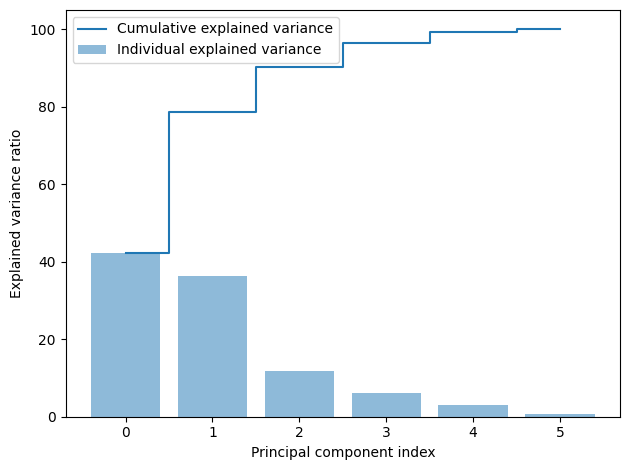

In [14]:
# Create the visualization plot
import matplotlib.pyplot as plt
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_var_exp)), cum_var_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
# Covariance matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(6,1),
                      eig_pairs[1][1].reshape(6,1)))
print("Matriz W:\n", matrix_w)
print(matrix_w.shape)

Matriz W:
 [[-0.4536448  -0.36611409]
 [-0.10981153 -0.44583054]
 [-0.4819419   0.27053607]
 [-0.2480689   0.58656306]
 [-0.42511661 -0.44370381]
 [-0.55463277  0.23038346]]
(6, 2)


## 6. Generate PC1 and PC2

In [16]:
# PC_1 and PC_2
Y = X_std.dot(matrix_w)
print(Y.shape)
Y2 = pd.DataFrame(Y, columns=["PC_1", "PC_2"])
Y2["Label"] = DATA["Label"]
Y2.head(5)

(762, 2)


,PC_1,PC_2,Label
0,0.837086,-0.416896,balsamic
1,-0.657441,-0.536364,balsamic
2,0.674211,-0.293262,balsamic
3,-1.245117,-2.065648,balsamic
4,2.785403,-1.864334,balsamic


## 7. Plot PCA

Mounted at /content/drive


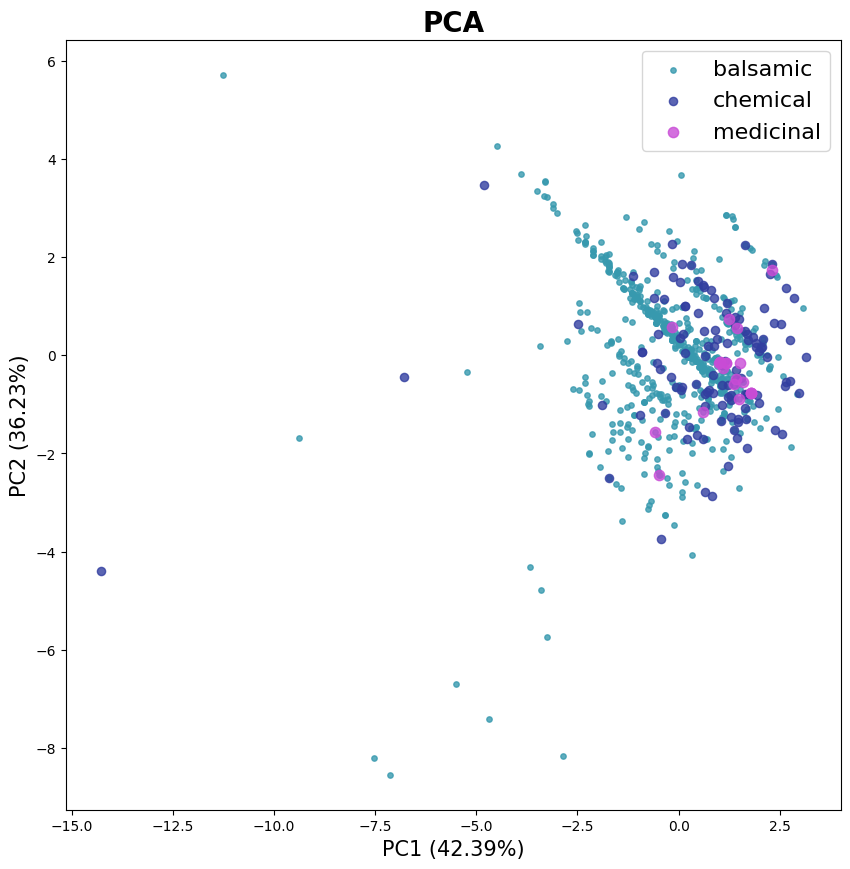

In [17]:
# Plot PCA

# Colors
from matplotlib.colors import ListedColormap
# Define labels
labels = 'balsamic', 'chemical', 'medicinal'
# Define colores
colors_data = ['#3799ae','#323ea0', "#c94cd6"]
# Define format
marker='o' "o" 'o'
# Shape size
s=15, 35, 55

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

# Show PCA
for label, color, marker, s in zip((labels),
                        (colors_data), (marker), (s)):
  plt.scatter(Y[y==label, 0],
              Y[y==label, 1],
              alpha=0.8,
              label=label,
              color=color,
              marker=marker,
              s=s)
# Add the percentage of variance
plt.xlabel("PC1 (%2.2f" % var_exp[0] +str("%)"), fontsize=15)
plt.ylabel("PC2 (%2.2f" %var_exp[1] +str("%)"), fontsize=15)

# Axes
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Legends
plt.legend(loc='best', fontsize=16)
plt.title("PCA", fontsize=20, fontweight="bold")

# Save figure
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
plt.savefig("PCA_natural_remedies.jpg", dpi=500)

links:
1. https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/
2. https://www.cienciadedatos.net/documentos/35_principal_component_analysis